<a href="https://colab.research.google.com/github/alina-bogdanovskaya/ML_in_Business_Mar2023/blob/lesson4/ML_in_business_HW04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-uplift catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached causalml-0.13.0.tar.gz (535 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing and models
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_by_percentile, weighted_average_uplift
from sklift.viz import plot_uplift_preds, plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/GB/ML in business/Lection4-20220325T130327Z-001/Lection4/data.csv')
pd.set_option('display.max_columns', None)

In [ ]:
data.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
data.treatment.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [ ]:
data.treatment = data.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [ ]:
data_train, data_valid = train_test_split(data, test_size=0.3, random_state=42)

In [ ]:
X_train = data_train.drop(['treatment', 'target'], axis=1)
y_train = data_train.target
treat_train = data_train.treatment

X_val = data_valid.drop(['treatment', 'target'], axis=1)
y_val = data_valid.target
treat_val = data_valid.treatment

In [ ]:
cat_feats = ['zip_code', 'channel']

metrics = {
    'model type': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'weighted avg uplift': [], 
    'qini coefficient': []
}

(0.12621579490482218, 0.10707336321448918)

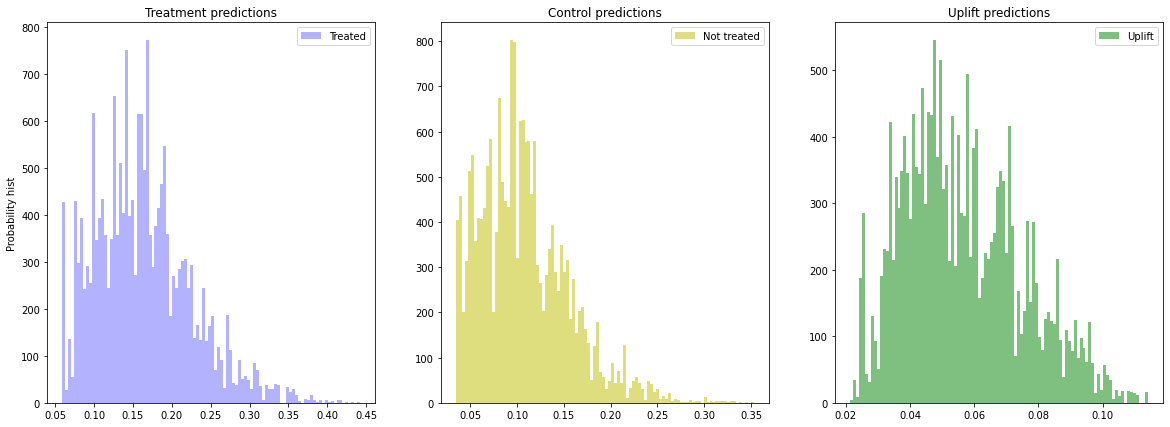

In [ ]:
N = 20000
sm = SoloModel(CatBoostClassifier(iterations=30, depth=3, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
uplift_full_data_sm = weighted_average_uplift(y_val, uplift_sm, treat_val, bins=10) 
qini_coeff_sm = qini_auc_score(y_val, uplift_sm, treat_val)

metrics['model type'].append('SoloModel')
metrics['uplift@10%'].append(sm_score_10)
metrics['uplift@20%'].append(sm_score_20)
metrics['weighted avg uplift'].append(uplift_full_data_sm)
metrics['qini coefficient'].append(qini_coeff_sm)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(sm_trmnt_preds, sm_ctrl_preds, bins=100);

sm_score_10, sm_score_20

In [ ]:
auqc = qini_auc_score(y_val, uplift_sm, treat_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0534


In [ ]:
# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_val, uplift_sm,  treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1272,648,0.294025,0.166667,0.127358,0.012774,0.014640,0.019430
10-20,1273,647,0.227808,0.140649,0.087159,0.011755,0.013668,0.018028
20-30,1265,655,0.192095,0.108397,0.083698,0.011076,0.012147,0.016439
30-40,1314,606,0.168189,0.095710,0.072479,0.010318,0.011951,0.015789
40-50,1271,649,0.163651,0.098613,0.065037,0.010377,0.011703,0.015641
50-60,1265,655,0.154150,0.126718,0.027433,0.010153,0.012998,0.016493
60-70,1266,654,0.150079,0.082569,0.067510,0.010038,0.010762,0.014717
70-80,1296,624,0.138889,0.089744,0.049145,0.009606,0.011442,0.014940
80-90,1267,653,0.106551,0.067381,0.039170,0.008668,0.009810,0.013091


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


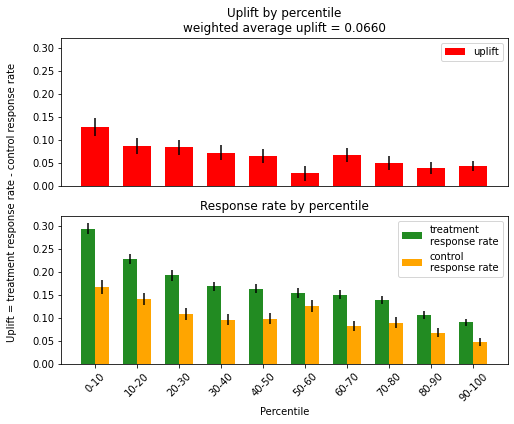

In [ ]:
# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar');

In [ ]:
ct = ClassTransformation(CatBoostClassifier(iterations=30, depth=3, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feats})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
uplift_full_data_ct = weighted_average_uplift(y_val, uplift_ct, treat_val, bins=10) 
qini_coeff_ct = qini_auc_score(y_val, uplift_ct, treat_val)

metrics['model type'].append('ClassTransformation')
metrics['uplift@10%'].append(ct_score_10)
metrics['uplift@20%'].append(ct_score_20)
metrics['weighted avg uplift'].append(uplift_full_data_ct)
metrics['qini coefficient'].append(qini_coeff_ct)

ct_score_10, ct_score_20

(0.1371533749515146, 0.11171337247744437)

(0.1041442535928005, 0.0900615194293532)

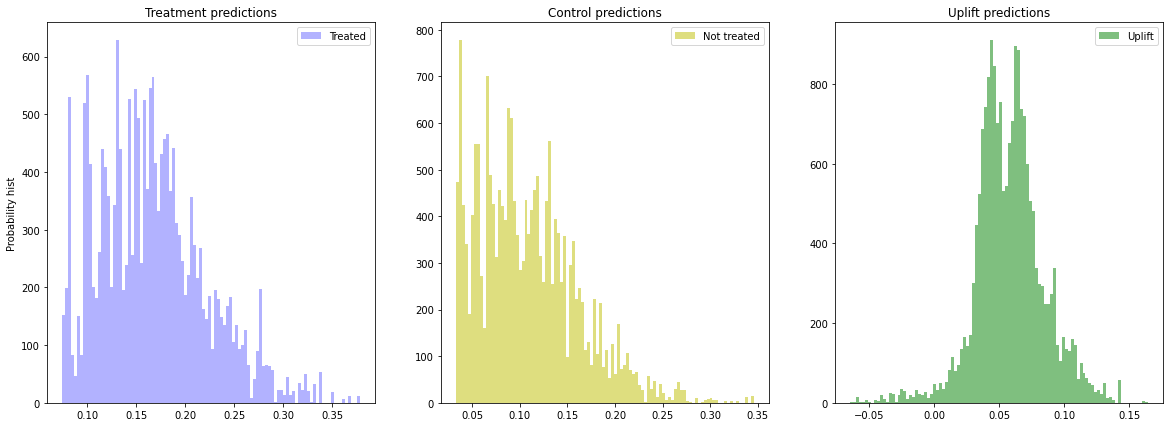

In [ ]:
tm = TwoModels(     
    estimator_trmnt=CatBoostClassifier(iterations=20, depth=3, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, depth=3, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)   

# method ='ddr_control' ('ddr_treatment') - зависимые модели
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_feats}, 
    estimator_ctrl_fit_params={'cat_features': cat_feats}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
uplift_full_data_tm = weighted_average_uplift(y_val, uplift_tm, treat_val, bins=10) 
qini_coeff_tm = qini_auc_score(y_val, uplift_tm, treat_val)

metrics['model type'].append('TwoModels')
metrics['uplift@10%'].append(tm_score_10)
metrics['uplift@20%'].append(tm_score_20)
metrics['weighted avg uplift'].append(uplift_full_data_tm)
metrics['qini coefficient'].append(qini_coeff_tm)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

tm_score_10, tm_score_20

In [ ]:
uplift_by_percentile(y_val,uplift_ct, treat_val, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1285,635,0.301167,0.162205,0.138963,0.012798,0.014629,0.019437
10-20,1245,675,0.212851,0.127407,0.085444,0.011601,0.012834,0.017300
20-30,1307,613,0.171385,0.128874,0.042510,0.010424,0.013533,0.017082
30-40,1272,648,0.192610,0.108025,0.084585,0.011057,0.012194,0.016461
40-50,1286,634,0.175739,0.116719,0.059019,0.010613,0.012752,0.016591
50-60,1264,656,0.160601,0.117378,0.043223,0.010327,0.012567,0.016266
60-70,1256,664,0.145701,0.091867,0.053833,0.009955,0.011209,0.014992
70-80,1286,634,0.127527,0.088328,0.039199,0.009302,0.011270,0.014613
80-90,1289,631,0.121800,0.060222,0.061578,0.009109,0.009471,0.013141


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


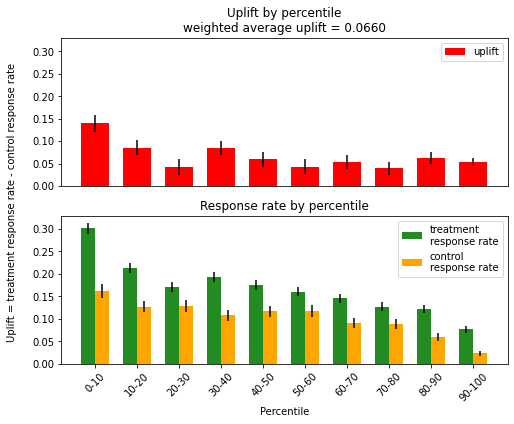

In [ ]:
plot_uplift_by_percentile(y_val, uplift_ct, treat_val, 
                          strategy='overall', kind='bar');

In [ ]:
pd.DataFrame(data=metrics)

,model type,uplift@10%,uplift@20%,weighted avg uplift,qini coefficient
0,SoloModel,0.126216,0.107073,0.066239,0.053356
1,ClassTransformation,0.137153,0.111713,0.066084,0.044328
2,TwoModels,0.104144,0.090062,0.066286,0.036764


Solo Model


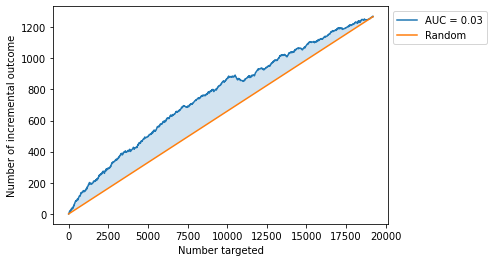

Two Model


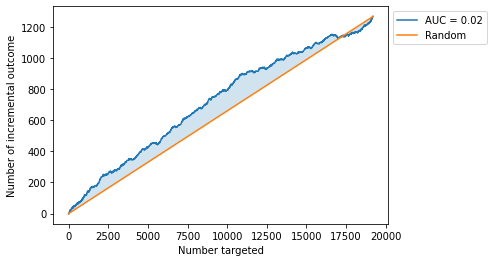

ClassTransform Model


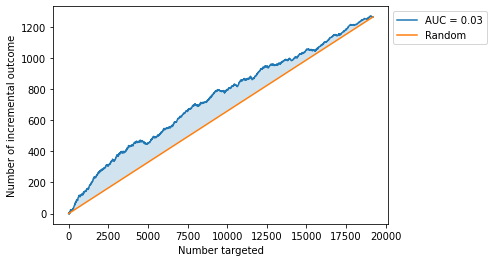

In [ ]:
print('Solo Model')
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()